In [4]:
!pip install gurobipy

In [2]:
import math

# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Function to read the .tsp file and extract the coordinates
def read_tsp_file(file_path):
    coordinates = []
    with open(file_path, 'r') as file:
        # Skip the header
        while True:
            line = file.readline()
            if line.strip() == "NODE_COORD_SECTION":
                break
        # Read the coordinates
        for line in file:
            if line.strip() == "EOF":
                break
            _, x, y = line.strip().split()
            coordinates.append((float(x), float(y)))
    return coordinates

# Calculate the distance matrix from the coordinates
def calculate_distance_matrix(coordinates):
    n = 3
    distance_matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = euclidean_distance(coordinates[i], coordinates[j])
    return distance_matrix

# Path to the .tsp file
file_path = r'C:\Users\manue\Downloads\qa194.tsp'

# Read the coordinates from the .tsp file
coordinates = read_tsp_file(file_path)

# Calculate the distance matrix
distance_matrix = calculate_distance_matrix(coordinates)
print(distance_matrix)

[[0, 372.0941512342277, 560.3036477804213], [372.0941512342277, 0, 195.13370816373165], [560.3036477804213, 195.13370816373165, 0]]


In [8]:

from gurobipy import Model, Env

# Initialize the Gurobi environment
env = Env(r"C:\gurobi\gurobi.lic")

# Create a new model with the specified environment
m = Model("TSP", env=env)

# ... rest of your script ...

Set parameter Username
Set parameter LogFile to value "C:\gurobi\gurobi.lic"
Academic license - for non-commercial use only - expires 2025-03-05


In [9]:
from gurobipy import Model, GRB, quicksum

# Assuming 'distance_matrix' and 'n' are already defined
# 'distance_matrix' is a 2D list of distances between cities
# Number of nodes
n = len(distance_matrix)

# Create variables
vars = {}
for i in range(n):
    for j in range(n):
        if i != j:  # No loops
            vars[i, j] = m.addVar(obj=distance_matrix[i][j], vtype=GRB.BINARY, name=f'x_{i}_{j}')
m.update()

# Add degree-2 constraint, and forbid loops
for i in range(n):
    m.addConstr(quicksum(vars[i, j] for j in range(n) if i != j) == 1, name=f"out_{i}")
    m.addConstr(quicksum(vars[j, i] for j in range(n) if i != j) == 1, name=f"in_{i}")

# Callback - use lazy constraints to eliminate sub-tours
def subtour_elimination(model, where):
    if where == GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(model._vars)
        selected = [(i, j) for i in range(n) for j in range(n) if i != j and vals[i, j] > 0.5]
        subtours = find_subtour(selected, n)
        for subtour in subtours:
            if len(subtour) < n:
                model.cbLazy(quicksum(model._vars[i, j] for i in subtour for j in subtour if i != j) <= len(subtour)-1)

# Function to find subtours
def find_subtour(edges, n):
    parent = list(range(n))

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    for i, j in edges:
        pi = find(i)
        pj = find(j)
        if pi != pj:
            parent[pi] = pj

    subtours = []
    for i in range(n):
        if find(i) == i:
            subtour = set(j for j in range(n) if find(j) == i)
            if len(subtour) > 1:
                subtours.append(subtour)
    return subtours

# Optimize the model
m._vars = vars
m.Params.lazyConstraints = 1
m.optimize(subtour_elimination)

# Output solution
if m.status == GRB.OPTIMAL:
    solution = m.getAttr('x', vars)
    selected_edges = [(i, j) for i in range(n) for j in range(n) if i != j and solution[i, j] > 0.5]
    print('Optimal tour: %s' % str(selected_edges))
    print('Optimal cost: %g' % m.objVal)
else:
    print('No optimal solution found.')

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 388 rows, 37442 columns and 74884 nonzeros
Model fingerprint: 0xb8218935
Variable types: 0 continuous, 37442 integer (37442 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.08s
Presolved: 388 rows, 37442 columns, 74884 nonzeros
Variable types: 0 continuous, 37442 integer (37442 binary)

Root relaxation: objective 8.854238e+03, 569 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 8854.23832    0  160          - 8854.2

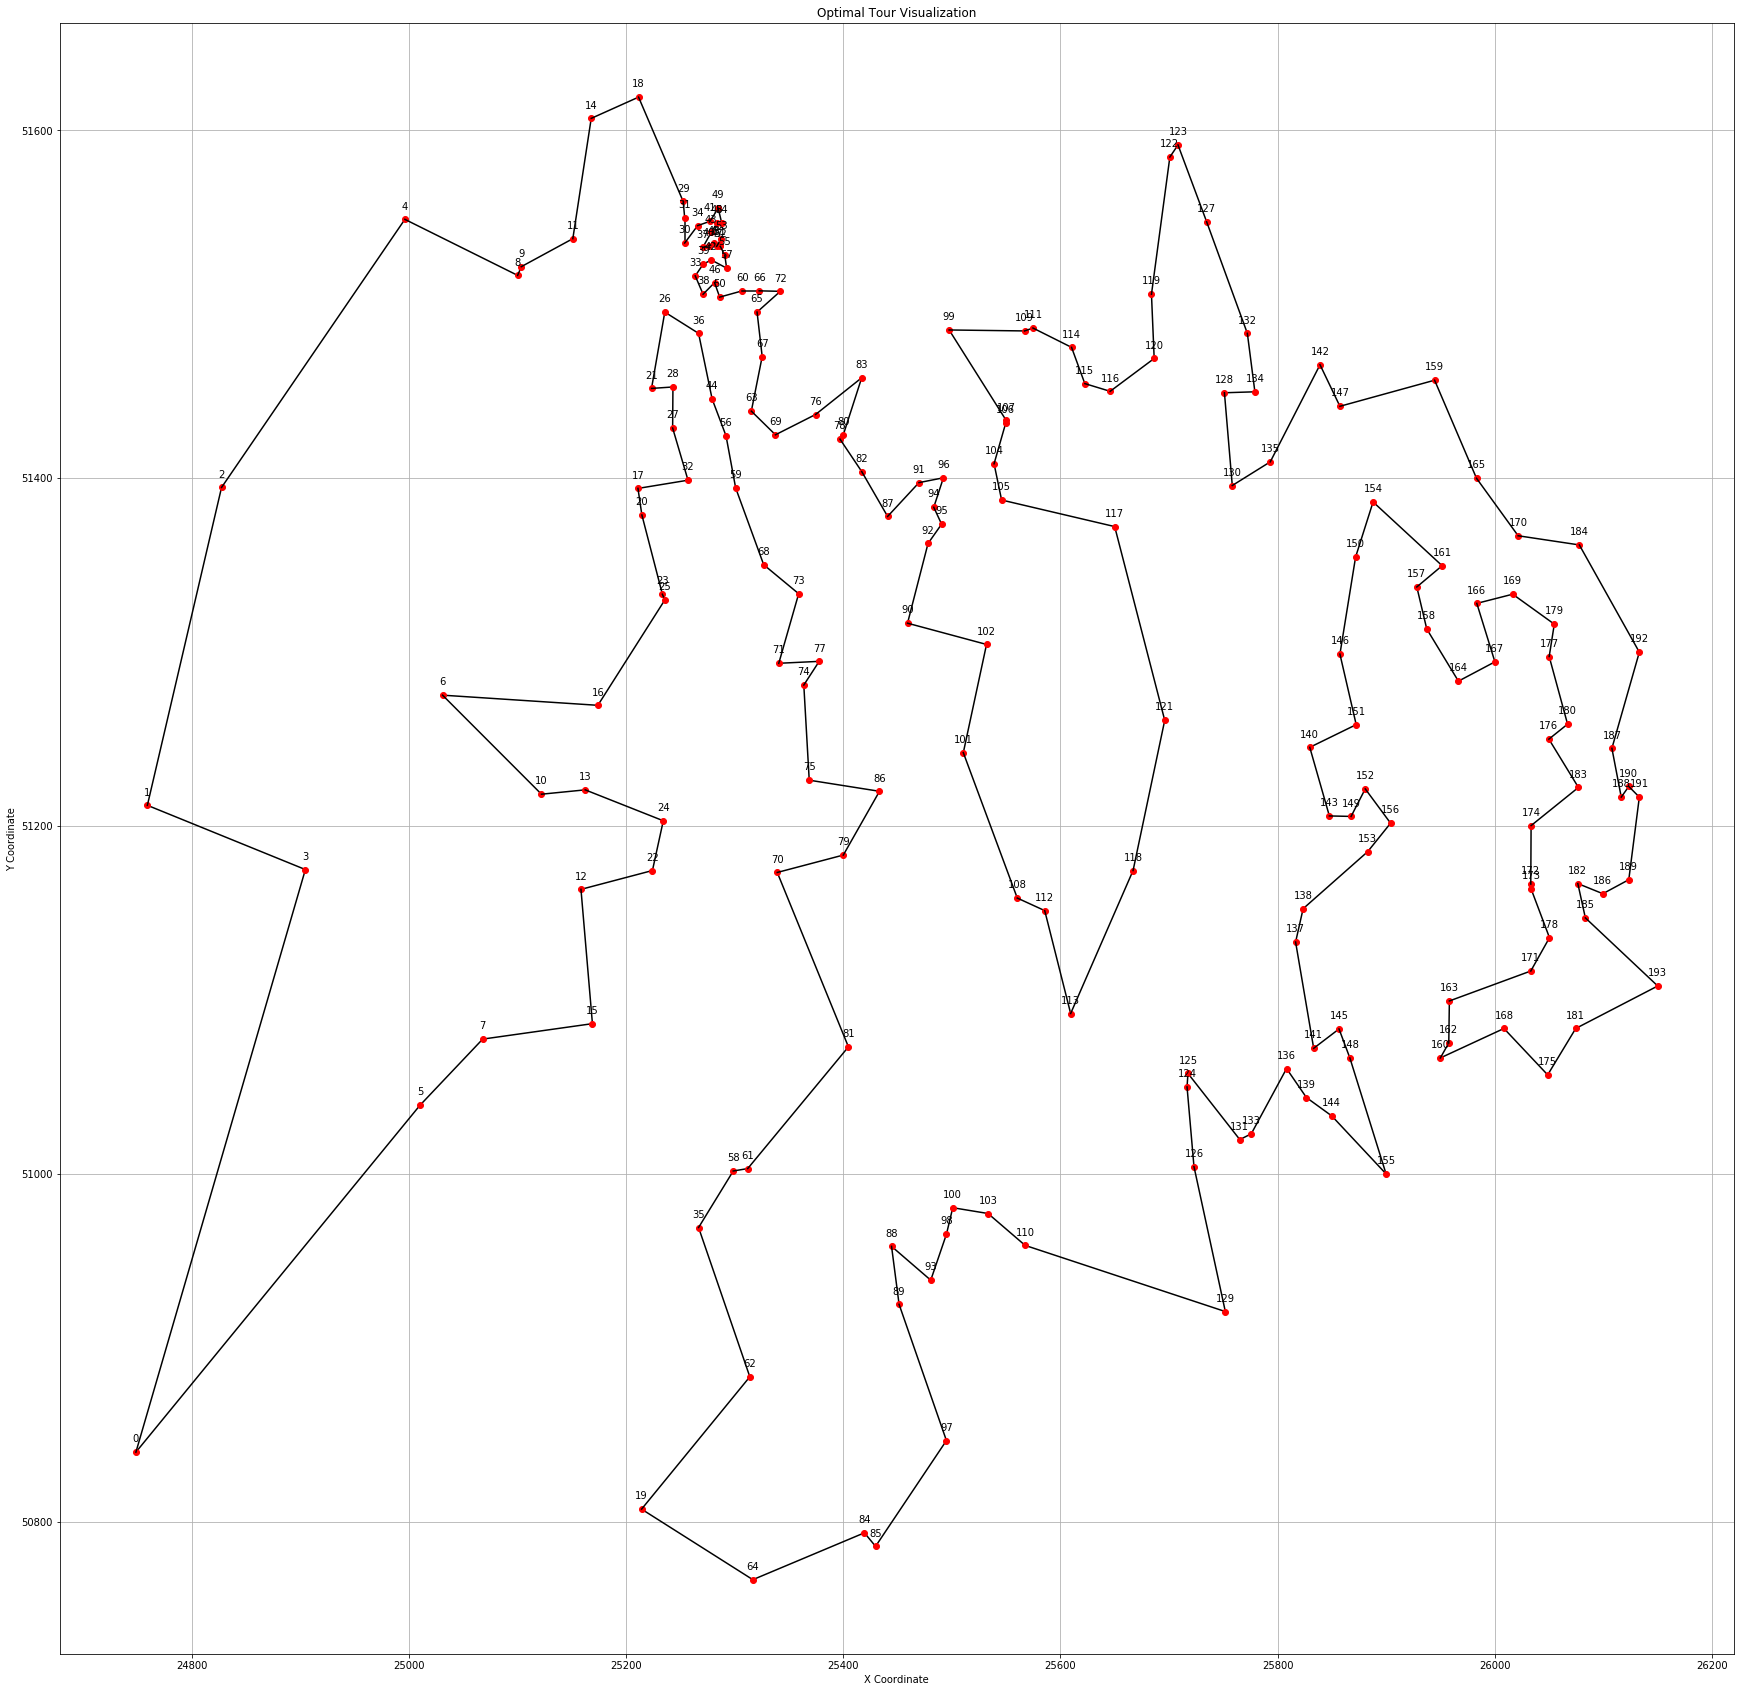

In [11]:
import matplotlib.pyplot as plt

# Draw the tour
plt.figure(figsize=(30, 30))
for edge in selected_edges:
    i, j = edge
    plt.plot([coordinates[i][0], coordinates[j][0]], [coordinates[i][1], coordinates[j][1]], 'k-')
    plt.plot(coordinates[i][0], coordinates[i][1], 'ro')

# Optionally add annotations for city indices
for idx, (x, y) in enumerate(coordinates):
    plt.annotate(idx, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Optimal Tour Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()